In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt
from wisps.simulations import selection_function as slf
import numpy as np
import pandas as pd

import numba
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

%matplotlib inline
#%%capture  output
import splat
import itertools
from tqdm import tqdm
from numba import cuda

In [2]:
#load in the data


In [3]:
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl') #the simulated spectral data
rf=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
min_max_scaler= pd.read_pickle(wisps.OUTPUT_FILES+'/min_max_scaler.pkl')#the min max scaler used to transform the data
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')

In [4]:
indices_to_use

{'H_2O-1/J-Cont H_2O-2/H_2O-1': 'L0-L5',
 'H_2O-1/J-Cont H-cont/H_2O-1': 'L5-T0',
 'H_2O-1/J-Cont CH_4/J-Cont': 'M7-L0',
 'H_2O-2/H_2O-1 H-cont/H_2O-1': 'T0-T5',
 'H_2O-2/H_2O-1 CH_4/H_2O-1': 'T5-T9',
 'H-cont/J-Cont CH_4/H_2O-2': 'Y dwarfs',
 'H-cont/H_2O-2 CH_4/H_2O-2': 'subdwarfs'}

In [5]:
mask=sf.snr1.apply(np.log10).between(-1, 3.5)

In [6]:
simulated_data=sf[mask]

In [7]:
#simulated_data['weight']=simulated_data.spt.apply(get_weight)

In [8]:
sampled_data=simulated_data

In [9]:
from scipy import stats
def f_test_comp(x):
    return stats.f.cdf(x, 2, 1, 0, scale=1)
sampled_data['f_test_cdf']=(sampled_data.spex_chi/sampled_data.line_chi).apply(f_test_comp)

In [10]:
#things that missed their classification 
sampled_data['missed_label']=sampled_data['sp_old'].apply(wisps.make_spt_number) != sampled_data['spt_new'].apply(wisps.make_spt_number)
sampled_data['missed_label']=1-sampled_data.missed_label.apply(int).apply(float)

In [11]:
import seaborn as sns

In [12]:
cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

In [13]:
sampled_data['missed_label_outside']= (sampled_data['spt_new'].apply(wisps.make_spt_number).between(17, 41)).apply(int)

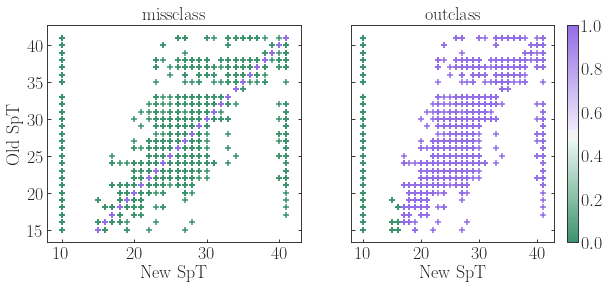

In [14]:
fig, ax=plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 4))

c=ax[0].scatter(sampled_data['spt_new'].apply(wisps.make_spt_number),sampled_data['sp_old'].apply(wisps.make_spt_number), c= sampled_data['missed_label'].values,
            marker='+', cmap=cmap)

ax[1].scatter(sampled_data['spt_new'].apply(wisps.make_spt_number),sampled_data['sp_old'].apply(wisps.make_spt_number), c= sampled_data['missed_label_outside'].values,
            marker='+', cmap=cmap)

ax[0].set_ylabel('Old SpT', fontsize=18)
ax[1].set_xlabel('New SpT', fontsize=18)
ax[0].set_xlabel('New SpT', fontsize=18)

ax[0].set_title('missclass', fontsize=18)
ax[1].set_title('outclass', fontsize=18)
plt.colorbar(c)

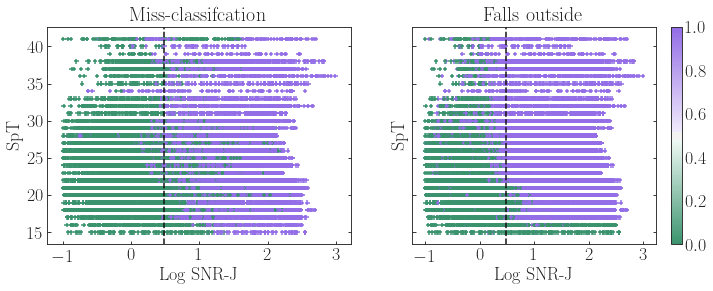

In [15]:
fig, ax=plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 4))
c=ax[0].scatter(sampled_data.snr1.apply(np.log10), 
            sampled_data.sp_old.apply(wisps.make_spt_number), marker='+',
            s=20, c=sampled_data['missed_label'].values, cmap=cmap, alpha=1.)

ax[1].scatter(sampled_data.snr1.apply(np.log10), 
            sampled_data.sp_old.apply(wisps.make_spt_number), marker='+',
            s=20, c=sampled_data['missed_label_outside'].values, cmap=cmap, alpha=1.)

ax[0].set_xlabel('Log SNR-J', fontsize=18)
ax[0].set_ylabel('SpT', fontsize=18.)

ax[1].set_xlabel('Log SNR-J', fontsize=18)
ax[1].set_ylabel('SpT', fontsize=18.)

ax[0].axvline(np.log10(3), linestyle='--', color='#111111')
ax[1].axvline(np.log10(3), linestyle='--', color='#111111')
ax[0].set_title('Miss-classifcation', fontsize=20)
ax[1].set_title('Falls outside', fontsize=20)
plt.colorbar(c)
plt.savefig(wisps.OUTPUT_FIGURES+'/missclassfiction_select.pdf')

In [16]:
sampled_data.shape

(30208, 23)

In [17]:
sampled_data.shape

(30208, 23)

In [18]:
sampled_data['Names']=['spctr'+ str(idx) for idx in sampled_data.index]

In [19]:
sampled_data['spt']=sampled_data['spt_new'].apply(wisps.make_spt_number)

In [20]:
#selection criteria
slc_crts=sel_crt.crts_from_file()

In [21]:
rf_features=['CH_4/H-Cont', 'CH_4/H_2O-1', 'CH_4/H_2O-2', 'CH_4/J-Cont',
       'H-cont/H_2O-1', 'H-cont/H_2O-2', 'H-cont/J-Cont', 'H_2O-1/J-Cont',
       'H_2O-2/H_2O-1', 'H_2O-2/J-Cont',  'spex_chi', 'snr2', 'snr1',
       'line_chi', 'x', 'f_test']

In [22]:
#df.columns

#### Define a bunch of selection processes

In [23]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df

def select_by_indices(df):
    #use spectral indices
    good_indices=[slc_crts[k] for k in indices_to_use.keys()]
    cands=[]
    #indices work in log-scale now
    
    for idx, k in zip(good_indices, indices_to_use.keys()):
        spt_range=indices_to_use[k]
        bs=idx.shapes
        bx=[x for x in bs if x.shape_name==spt_range][0]
        df_to_use=wisps.Annotator.reformat_table(df[[idx.xkey, idx.ykey]]).applymap(np.log10)
        selec_indx_array=bx.select(df_to_use).index
        ls=df.iloc[selec_indx_array].Names
        df['selected_by_{}'.format(spt_range)]=df.spt_new.apply(lambda x: wisps.is_in_that_classification(x, spt_range) )
        cands.append(ls)
    
    merged = np.array(list(itertools.chain(*cands)))
    final_cands=np.unique(merged.flatten())
    #add_anotation_to_data_frame
    
    return (df.Names.isin(final_cands))

def select_by_f_test(df):
    return df['f_test_cdf']<.4

@numba.jit
def select_by_random_forest(df):
    #use the classification given by my rf classifier
    prblm_feats=['line_chi', 'spex_chi', 'H_2O-2/J-Cont', 'H-cont/J-Cont', 'H_2O-1/J-Cont', 'H-cont/H_2O-1', 'snr2', 'x']
    
    #apply logs to problematic features the same way I did on my classification
    df[prblm_feats]=df[prblm_feats].applymap(np.log10).replace(np.inf, np.nan).replace(-np.inf, np.nan).replace(np.nan, -999999.9)
    
    #scale the features 
    x=df[rf_features].replace(-np.inf, np.nan).replace(np.nan,  -999999.9).values
    
    #check for 15 columns
    print (x.shape)
    pred_set=min_max_scaler.transform(x)
    labels=rf.predict(pred_set)
    
    #return the predictions
    
    
    return labels


#### Add missing features to the data

In [24]:
sampled_data=sampled_data.rename(columns={"f":"f_test"})

In [25]:
sampled_data['x']=sampled_data.spex_chi/sampled_data.line_chi

In [26]:
df=sampled_data

In [27]:
sampled_data.shape

(30208, 26)

In [28]:
df['f_test_label']=(select_by_f_test(df).apply(int))*df.missed_label.values

In [29]:
df['rf_label']=(select_by_random_forest(wisps.Annotator.reformat_table(df)))*df.missed_label.values

(30208, 16)


In [30]:
df['index_label']=(select_by_indices(df).apply(int))*df.missed_label.values

In [31]:
df['idx_ft_label']=np.logical_and(df['index_label'].apply(bool), df['f_test_label'].apply(bool) ).apply(int)

In [32]:
df['idx_ml_label']=np.logical_and(df['index_label'].apply(bool), df['rf_label'].apply(bool) ).apply(int)

In [33]:
import seaborn as sns 
cmap=sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [34]:
df['logsnr']=df['snr2'].apply(np.log10)

In [35]:
from matplotlib.ticker import MultipleLocator

In [36]:
REF_SELECTION_DATA_SET=df

In [37]:
@numba.jit
def probability_of_selection(vals, method='f_test_label'):
    """
    probablity of selection for a given snr and spt
    """
    ref_df=REF_SELECTION_DATA_SET
    spt, snr=vals
    #self.data['spt']=self.data.spt.apply(splat.typeToNum)
    floor=np.floor(spt)
    floor2=np.log10(np.floor(snr))
    if floor2 < np.log10(3.):
        return 0.
    else:
        return np.nanmean(ref_df[method][(ref_df.spt==floor) &(ref_df.snr1.apply(np.log10).between(floor2, floor2+.3))])

@numba.vectorize(['float32(float32, float32)','float64(float64, float64)'])
def selection_function(spt, snr):
    return  probability_of_selection((spt, snr))

In [38]:
df2=pd.DataFrame()
snrs=df.snr1.values
spts=df.spt.values
df2['snr']=snrs
df2['spt']=spts
df2['f_test_label']=selection_function(spts, snrs)
df2['rf_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='rf_label')
df2['index_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='index_label')

In [39]:
df2['idx_ft_label']=df2[['spt', 'snr']].apply(probability_of_selection, axis=1, method='idx_ft_label')

In [40]:
df2['logsnr']=df2.snr.apply(np.log10)

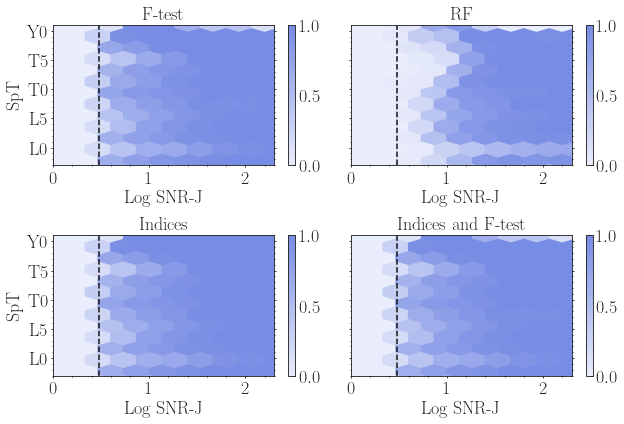

In [41]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(6*1.5, 4*1.5), sharex=False, sharey=True)
df2.plot.hexbin(x='logsnr', y='spt', C='f_test_label', reduce_C_function=np.nanmean, gridsize=15, cmap=cmap, ax=ax[0][0])
df2.plot.hexbin(x='logsnr', y='spt', C='rf_label', reduce_C_function=np.nanmean, gridsize=15, cmap=cmap, ax=ax[0][1])
df2.plot.hexbin(x='logsnr', y='spt', C='index_label', reduce_C_function=np.nanmean, gridsize=15, cmap=cmap, ax=ax[1][0])
df2.plot.hexbin(x='logsnr', y='spt', C='idx_ft_label', reduce_C_function=np.nanmean, gridsize=15, cmap=cmap, ax=ax[1][1])

#ax[0][0].scatter( sf.data.snr1.apply(np.log10), sf.data.spt, marker='+', color='#111111', alpha=.05)


ax[0][0].set_title('F-test', fontsize=18)
ax[0][1].set_title('RF', fontsize=18)
ax[1][0].set_title('Indices', fontsize=18)
ax[1][1].set_title('Indices and F-test', fontsize=18)

for a in np.concatenate(ax):
    a.set_xlabel('Log SNR-J', fontsize=18)
    a.set_ylabel('SpT', fontsize=18)
    a.axvline(np.log10(3), linestyle='--', color='#111111')
    

    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor',direction='inout')
    
    a.minorticks_on()
    a.set_yticks(np.arange(17, 41),  minor=True)
    a.set_yticks([20, 25, 30, 35, 40], minor=False)
    a.set_yticklabels(['L0', 'L5', 'T0', 'T5', 'Y0'], minor=False)
    a.set_xlim([0., 2.3])
    a.set_ylim([17., 41.])
    
plt.tight_layout()

#fig.axes[3].set_title(r'$\mathcal{S}$')
#fig.axes[2].set_title(r'$\mathcal{S}$')

plt.savefig(wisps.OUTPUT_FIGURES+'/selection_function_samples.pdf', bbox_inches='tight', dpi=200)

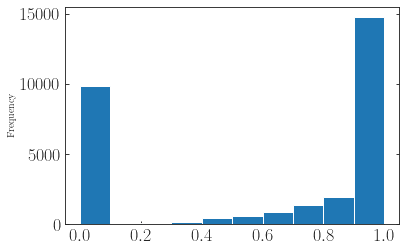

In [42]:
df2.f_test_label.plot(kind='hist')

In [43]:
cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

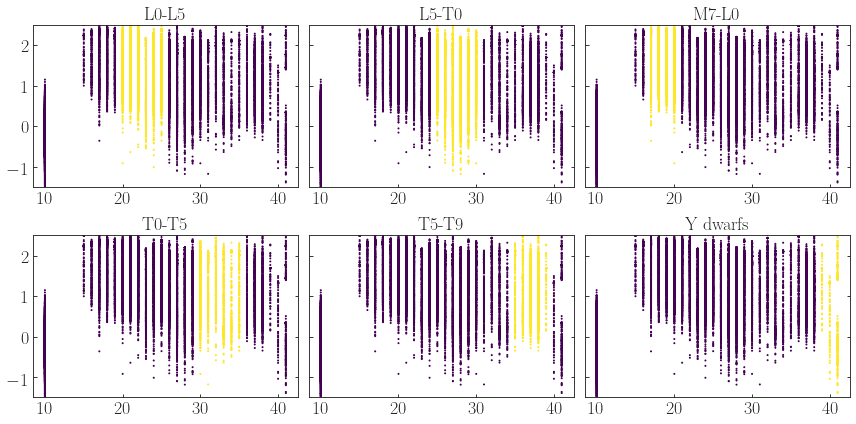

In [44]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(8*1.5, 4*1.5), sharex=False, sharey=True)

for a, grp in zip(np.concatenate(ax), indices_to_use.values() ):
    c=a.scatter(df.spt, df.logsnr, c=df['selected_by_{}'.format(grp)], s=1., cmap='viridis')
    
    a.set_title(grp, fontsize=18)

    #a.set_xlabel('Log SNR-J', fontsize=18)
    #a.set_ylabel('SpT', fontsize=18)
    a.set_ylim([-1.5, 2.5])

#plt.colorbar(c)
    
plt.tight_layout()

### Apply these to the simulations

In [45]:
df2.to_pickle(wisps.OUTPUT_FILES+'/selection_function_lookup_table.pkl')

In [1]:
import wisps

In [5]:
wisps.is_in_that_classification('T7', 'T5-Y0')

True

In [48]:
'L0-L5'[-2:], 'L0-L5'[:2]

('L5', 'L0')